In [53]:
from typing import TypedDict,Literal
from langgraph.graph import StateGraph,START,END
from langchain_cohere import ChatCohere
from dotenv import load_dotenv
from pydantic import BaseModel,Field

In [ ]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal["Positive","Negative"]
    diagnosis:dict
    response:str

In [55]:
load_dotenv()
llm=ChatCohere(model="command-r-plus-08-2024")

In [56]:
class SentimentSchema(BaseModel):
    Type:Literal["Positive","Negative"]=Field(description="Based on the description differentiate whether the review is Positive or Negative")
    
llm_with_structured_output=llm.with_structured_output(SentimentSchema)

In [57]:
class diagnosis_result(BaseModel):
    Issue_type:str=Field(description="Based on the review, just tell what is the type of issue?")
    Tone:str=Field(description="Based on the review, just tell what is the type of tone of customer?")
    Urgency:Literal["High","Low","Moderate"]=Field(description="Based on the review, just tell what is the level of urgency of customer,wheather it is High,Low or Moderate")
    
llm_with_diagnosis_output=llm.with_structured_output(diagnosis_result)

In [58]:
def find_sentiments(state:ReviewState)->dict:
    prompt=f"Based in the review from customer, differentiate whether the review is Positive or Negative.Here is the review,\n {state["review"]}"
    sentiment=llm_with_structured_output.invoke(prompt)
    return {"sentiment":sentiment.Type}

def check_condition(state:ReviewState)->Literal["run_diagnosis","positive_response"]:
    if state["sentiment"] =="Positive":
        return "positive_response"
    else:
        return "run_diagnosis"


def run_diagnosis(state:ReviewState)->dict:
    prompt=f"So based on this review\n {state["review"]} \n Please do find the Issue_type,Tone of speech and Urgency of the customer as this is negative review for us"
    result=llm_with_diagnosis_output.invoke(prompt)
    return {"diagnosis":result.model_dump()}


def positive_response(state:ReviewState)->dict:
    prompt=f"Based on this positive review,\n {state["review"]} \n Write a thankful message for the customer"
    result=llm.invoke(prompt)
    return {"response":result.content}


def negative_response(state:ReviewState)->dict:
    prompt=f"Based on this Negative review,\n {state["review"]} \n and {state["diagnosis"]}\n .Write a Sorry message for the customer telling that problem will be solved shortly"
    result=llm.invoke(prompt)
    return {"response":result.content}

In [59]:
graph=StateGraph(ReviewState)

graph.add_node("find_sentiments",find_sentiments)
graph.add_node("run_diagnosis",run_diagnosis)
graph.add_node("positive_response",positive_response)
graph.add_node("negative_response",negative_response)

graph.add_edge(START,"find_sentiments")
graph.add_conditional_edges("find_sentiments",check_condition)
graph.add_edge("run_diagnosis","negative_response")
graph.add_edge("positive_response",END)
graph.add_edge("negative_response",END)

workflow=graph.compile()

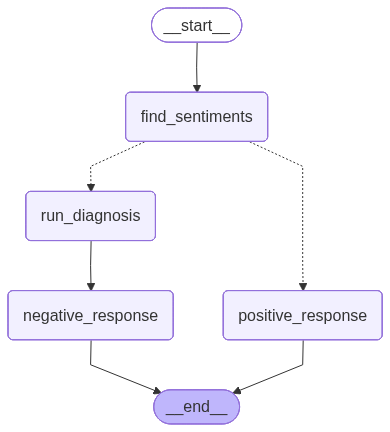

In [60]:
workflow

In [ ]:
review = """
    I am extremely disappointed with my recent experience at your restaurant. 
    I waited over 45 minutes for my food, and when it finally arrived, it was cold. 
    The waiter was rude and dismissive when I complained. This is completely unacceptable! 
    I need someone to contact me immediately about this matter.
"""

final_result=workflow.invoke({"review":review})

In [62]:
final_result

{'review': '\nI am extremely disappointed with my recent experience at your restaurant. \nI waited over 45 minutes for my food, and when it finally arrived, it was cold. \nThe waiter was rude and dismissive when I complained. This is completely unacceptable! \nI need someone to contact me immediately about this matter.\n',
 'sentiment': 'Negative',
 'diagnosis': {'Issue_type': 'Long wait time, poor food quality, and unsatisfactory customer service',
  'Tone': 'Angry, frustrated, and demanding',
  'Urgency': 'High'},
 'response': 'Dear [Customer Name],\n\nWe are deeply sorry for the unsatisfactory experience you had at our restaurant. Waiting for an extended period, only to receive cold food and encounter rude service, is not the standard we aim to uphold. Your feedback is crucial in helping us identify and rectify these issues promptly.\n\nThe long wait times are certainly not what we strive for, and we understand the frustration it causes. We are investigating the reasons for the dela